In [1]:
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, regularizers
from keras import backend as K

from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
train_path = 'data/train/'
test_path = 'data/test/'

train_image_path = 'cars_train/'
test_image_path = 'cars_test/'

In [3]:
img_width, img_height = 224, 224
nb_train_samples = 6488
nb_validation_samples = 1615
epochs = 100
batch_size = 32
n_classes = 196

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    zoom_range=0.2,
    #fill_mode = 'constant',
    #cval = 1,
    rotation_range = 5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 6488 images belonging to 196 classes.
Found 1615 images belonging to 196 classes.


In [5]:
def build_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    for layer in base_model.layers:
        layer.trainable = False
    
    # Flatten the results from conv block
    x = Flatten()(base_model.output)
    
    #add another fully connected layers with batch norm and dropout
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.8)(x)
    
    #add another fully connected layers with batch norm and dropout
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.8)(x)
    
    #add logistic layer with all car classes or output layer
    output = Dense(
        n_classes, activation='softmax', 
        kernel_initializer='random_uniform', bias_initializer='random_uniform', 
        bias_regularizer=regularizers.l2(0.01), name='output'
    )(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

In [6]:
def save_model(model, fileName):
    model_json = model.to_json()
    with open(fileName + ".json", "w") as json_file:
        json_file.write(model_json)
    
    model.save_weights(fileName + ".h5")
    print("Saved model to disk")

In [7]:
def show_accuracy(history, filename):
    plt.plot(history.history['val_acc'], 'r')
    plt.plot(history.history['acc'], 'b')
    plt.title('Performance of model ' + 'VGG16')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs No')
    plt.show()
#     plt.savefig(filename)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Epoch 31/100
202/202 [==============================] - 57s 284ms/step - loss: 3.8730 - acc: 0.2624 - val_loss: 2.2010 - val_acc: 0.4625
Epoch 32/100
202/202 [==============================] - 57s 283ms/step - loss: 3.7852 - acc: 0.2724 - val_loss: 2.1761 - val_acc: 0.4725
Epoch 33/100
202/202 [==============================] - 59s 291ms/step - loss: 3.7200 - acc: 0.2794 - val_loss: 2.1465 - val_acc: 0.4800
Epoch 34/100
202/202 [==============================] - 58s 286ms/step - loss: 3.6442 - acc: 0.2907 - val_loss: 2.1175 - val_acc: 0.4825
Epoch 35/100
202/202 [==============================] - 58s 286ms/step - loss: 3.5850 - acc: 0.3001 - val_loss: 2.0740 - val_acc: 0.5025
Epoch 36/100
202/202 [==============================] - 59s 294ms/step - loss: 3.4823 - acc: 0.3077 - val_loss: 2.0724 - val_acc: 0.5019
Epoch 37/100
202/202 [==============================] - 58s 285ms/step - loss: 3.3724 - acc: 0.3127 - val_loss: 2.0428 - val_acc: 0.5100
Epoch 38/100
202/202 [===================

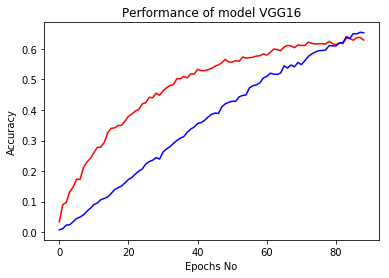

Saved model to disk


<Figure size 432x288 with 0 Axes>

In [8]:
base_model = build_vgg16_model()

# Set initial training 
adam = RMSprop(decay=1e-4, lr=0.0001)
base_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print(base_model.summary())

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')
history = base_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[earlystop]
)

show_accuracy(history, 'models/vgg16/VGG16' + '_initialModel_plot.png')
save_model(base_model, 'models/vgg16/vgg16_initialModel')

# Set layer to retrain
for layer in base_model.layers[:15]:
    layer.trainable = False

for layer in base_model.layers[15:]:
    layer.trainable = True

Epoch 1/100
202/202 [==============================] - 65s 321ms/step - loss: 1.2546 - acc: 0.6797 - val_loss: 1.5296 - val_acc: 0.6462
Epoch 2/100
202/202 [==============================] - 62s 308ms/step - loss: 1.1541 - acc: 0.7002 - val_loss: 1.4555 - val_acc: 0.6569
Epoch 3/100
202/202 [==============================] - 61s 303ms/step - loss: 1.0948 - acc: 0.7120 - val_loss: 1.3995 - val_acc: 0.6775
Epoch 4/100
202/202 [==============================] - 61s 303ms/step - loss: 1.0087 - acc: 0.7311 - val_loss: 1.3481 - val_acc: 0.6844
Epoch 5/100
202/202 [==============================] - 64s 316ms/step - loss: 0.9806 - acc: 0.7431 - val_loss: 1.3593 - val_acc: 0.6756
Epoch 6/100
202/202 [==============================] - 63s 312ms/step - loss: 0.9170 - acc: 0.7610 - val_loss: 1.2839 - val_acc: 0.6975
Epoch 7/100
202/202 [==============================] - 62s 309ms/step - loss: 0.8739 - acc: 0.7680 - val_loss: 1.2846 - val_acc: 0.6994
Epoch 8/100
202/202 [===========================

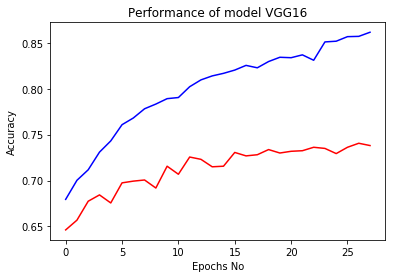

Saved model to disk


<Figure size 432x288 with 0 Axes>

In [10]:
sgd = SGD(lr=0.0001, decay=1e-4, momentum=0.9, nesterov=True)
# sgd = Adam(lr=0.0001, decay=1e-4)
base_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

history = base_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[earlystop]
)

show_accuracy(history,'models/vgg16/VGG16' + '_finalModel_plot.png')

save_model(base_model, 'models/vgg16/vgg16_finalModel')

# Evaluate VGG16 Model

In [12]:
base_model.evaluate_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)

NameError: name 'base_model' is not defined

In [ ]:
pred = base_model.predict_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
predicted = np.argmax(pred, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

In [ ]:
df = pd.read_csv('car_train.csv')

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, np.argmax(pred, axis=1))
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
print('Classification Report')
print(classification_report(validation_generator.classes, predicted, target_names=df['class'].unique(), labels=range(len(df['class'].unique()))))

# Predict single

In [6]:
import cv2
from keras.models import model_from_json

In [7]:
with open('models/vgg16/vgg16_finalModel.json', 'r') as f:
    model = model_from_json(f.read())

model.load_weights('models/vgg16/vgg16_finalModel.h5')

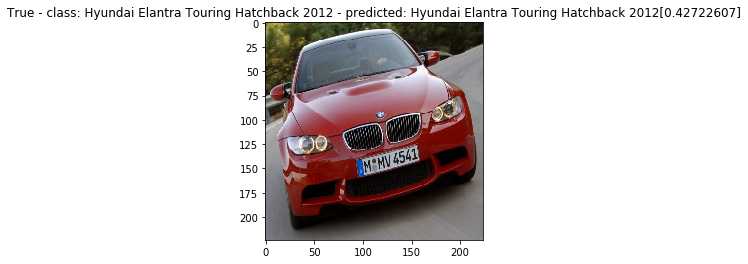

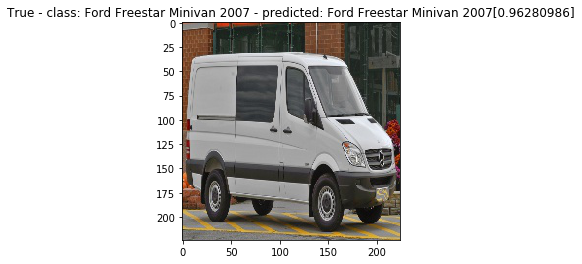

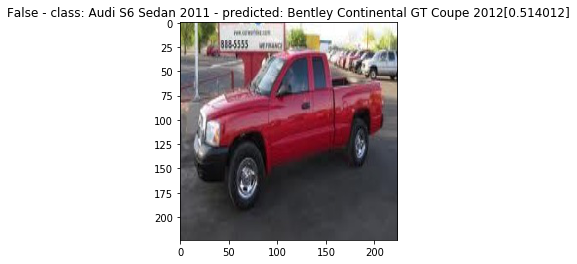

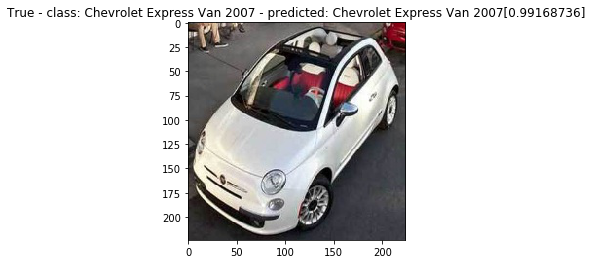

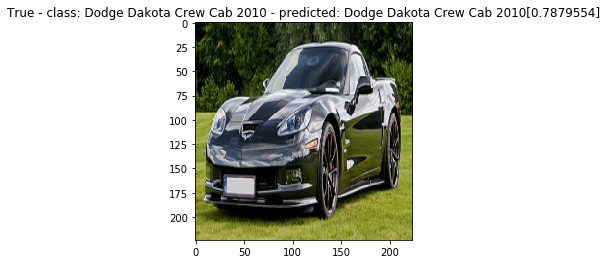

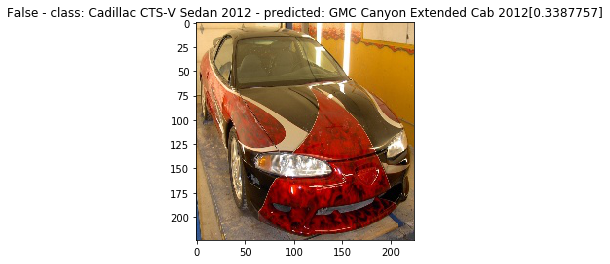

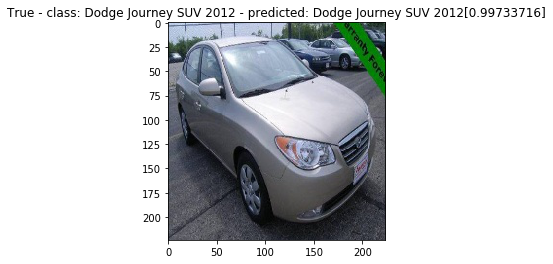

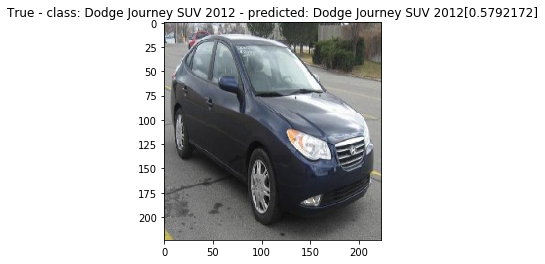

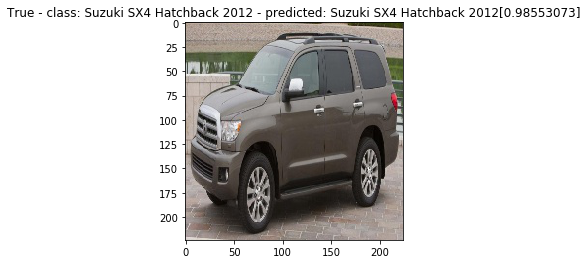

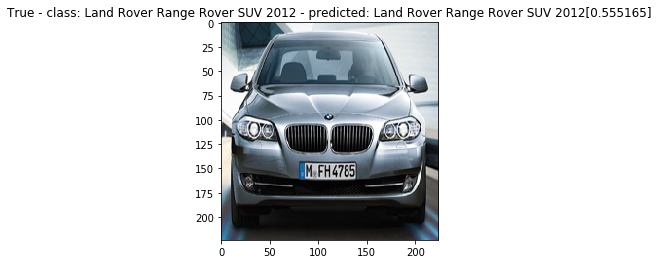

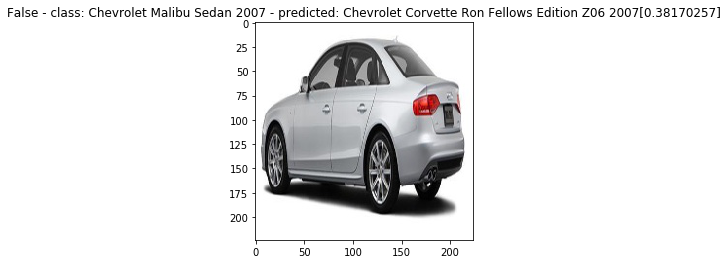

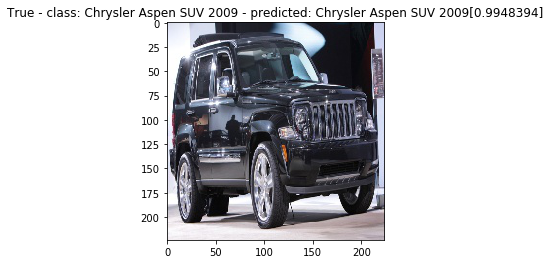

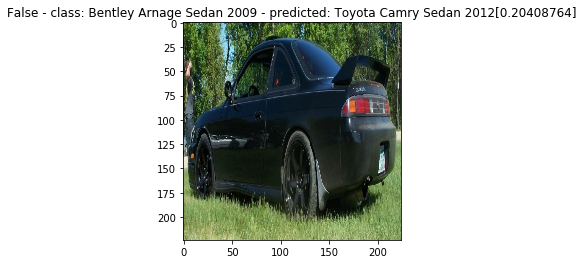

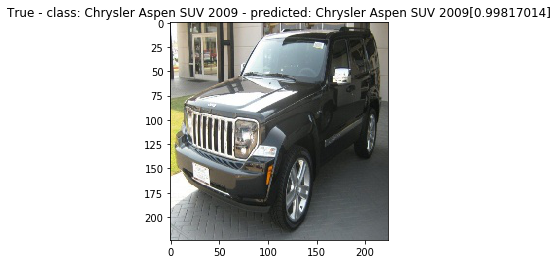

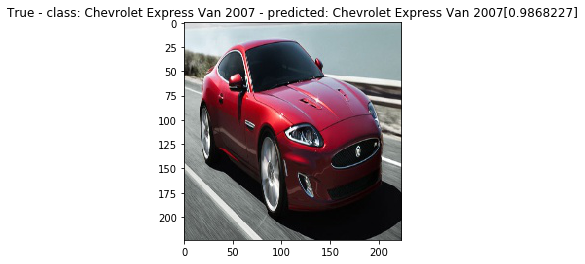

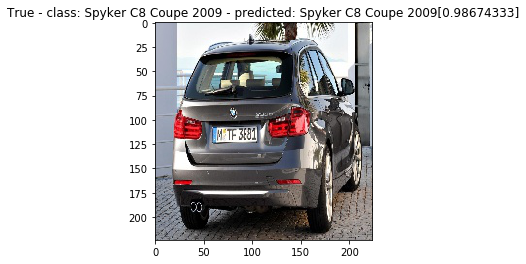

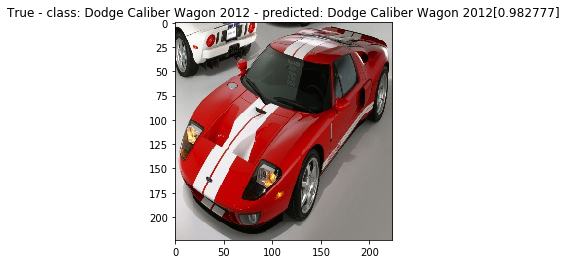

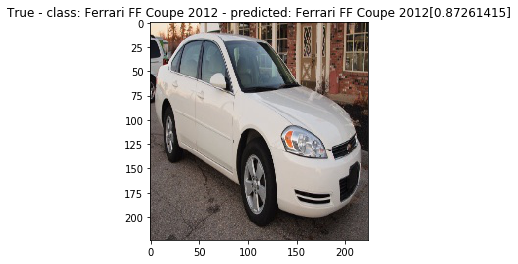

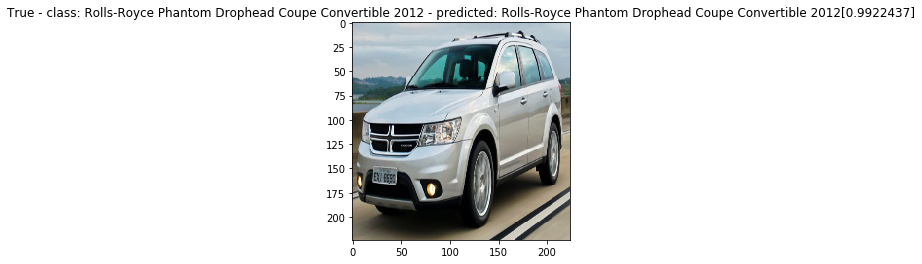

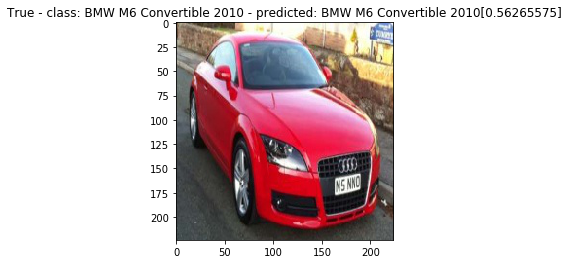

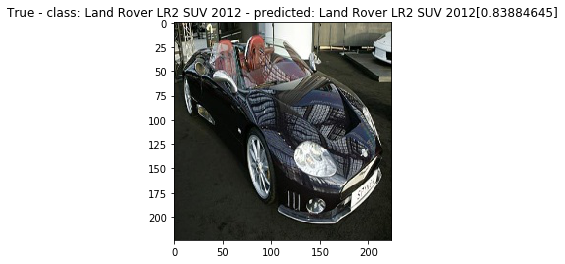

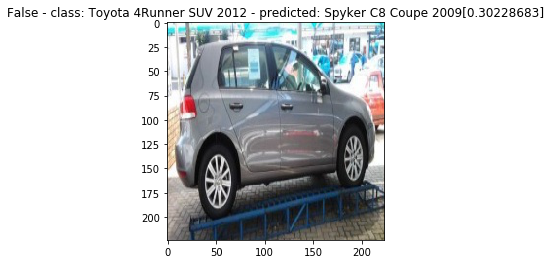

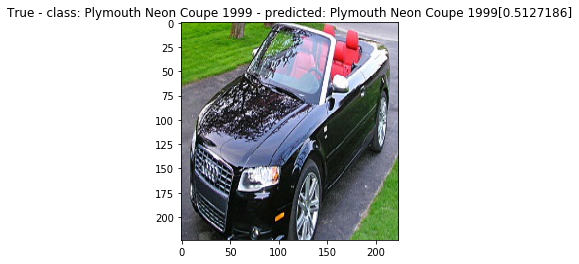

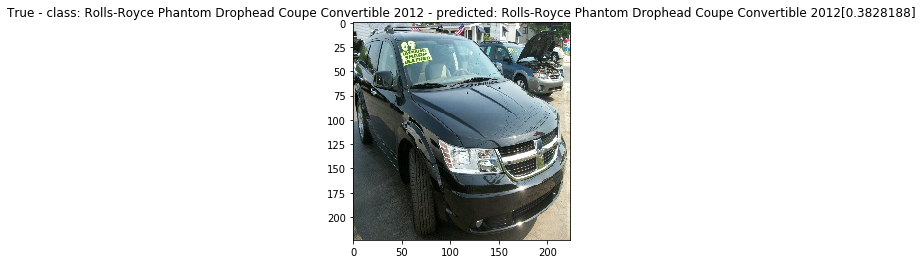

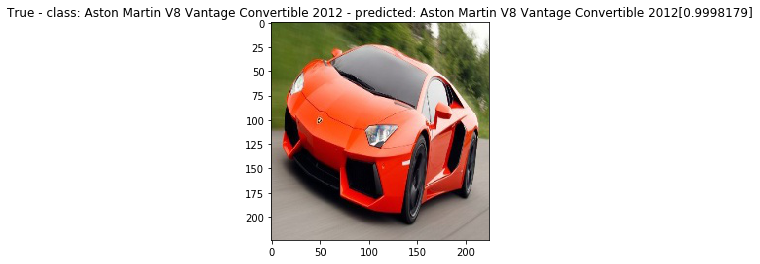

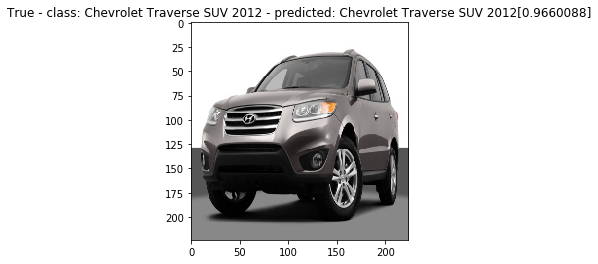

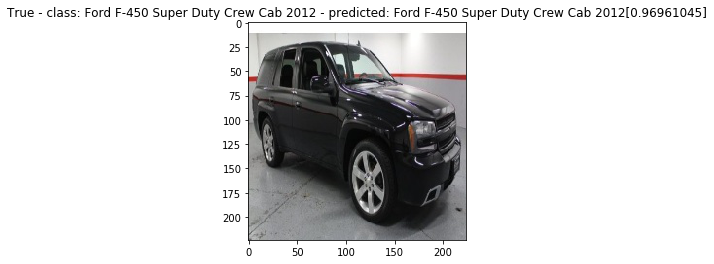

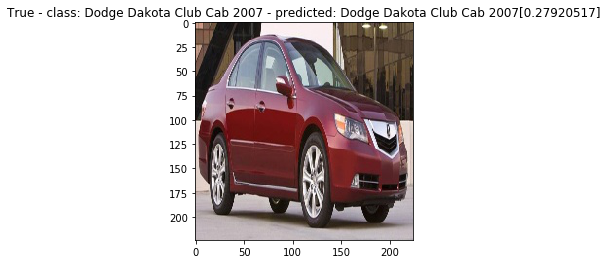

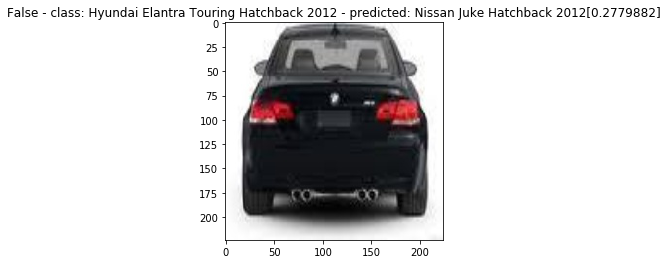

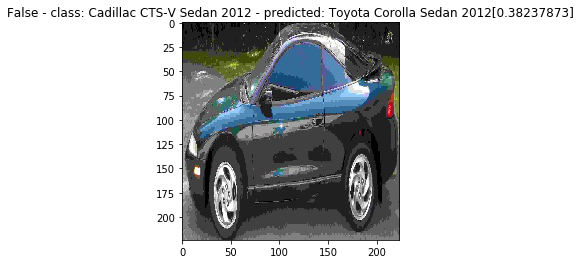

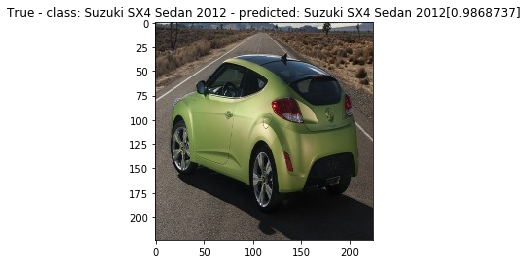

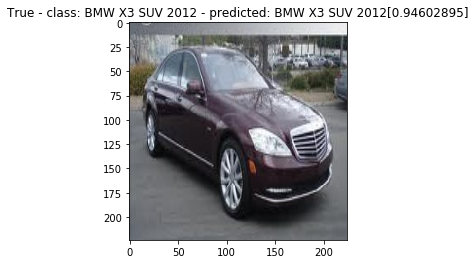

In [25]:
image_batch, classes_batch = next(validation_generator)
predicted_batch = model.predict(image_batch)

is_predicted_true = []

for k in range(0,image_batch.shape[0]):
    image = image_batch[k]
    pred = predicted_batch[k]
    the_pred = np.argmax(pred)
    predicted = df['class'][the_pred]
    val_pred = max(pred)
    the_class = np.argmax(classes_batch[k])
    value = df['class'][np.argmax(classes_batch[k])]
    plt.figure(k)
    isTrue = (the_pred == the_class)
    
    if isTrue:
        is_predicted_true.append(isTrue)
    
    plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
    plt.imshow(image)

In [1]:
print('Predicted correct {} out of {} validation'.format(len(is_predicted_true), image_batch.shape[0]))

NameError: name 'is_predicted_true' is not defined